In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader, Dataset
from timm import create_model
from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
root_dir = "/kaggle/input/Curated X-Ray Dataset"
class_folders = os.listdir(root_dir)
class_folders

['Normal', 'COVID-19', 'Pneumonia-Viral', 'Pneumonia-Bacterial']

In [4]:
# Mapping the class labels to numeric values
label_mapping = {
    "Normal": 0,
    "Pneumonia-Bacterial": 1,
    "Pneumonia-Viral": 1,  
    "COVID-19": 2
}

In [5]:
# List the class folders 
class_folders = os.listdir(root_dir)

# Prepare a list to store the data
data = []

# Iterate through each class folder and extract image filenames
for class_folder in class_folders:
    class_folder_path = os.path.join(root_dir, class_folder)
    
    if os.path.isdir(class_folder_path):  
        # Map the class folder to its corresponding label
        if class_folder in label_mapping:
            numeric_label = label_mapping[class_folder]
            for image_name in os.listdir(class_folder_path):
                image_id = os.path.join(class_folder, image_name)  # full filename with extension
                data.append([image_id, numeric_label])

df = pd.DataFrame(data, columns=["image_id", "label"])

# Save the DataFrame to a CSV file
csv_path = "/kaggle/working/Curated_chest_X-ray.csv"
df.to_csv(csv_path, index=False)

In [6]:
csv = "/kaggle/working/Curated_chest_X-ray.csv"

In [7]:
df['label'].value_counts()

label
1    4657
0    3270
2    1281
Name: count, dtype: int64

In [8]:
df.head(2)

,image_id,label
0,Normal/Normal (2814).jpg,0
1,Normal/Normal (1525).jpg,0


In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
NUM_CLASSES = 3 
LEARNING_RATE = 3e-5 
WEIGHT_DECAY = 5e-4  
NUM_EPOCHS = 3
LAMBDA_KOLEO = 0.9  #.7
BETA = 0.5

In [10]:
# Custom Dataset
class MedicalImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.data_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
# Data Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [12]:
from torch.utils.data import random_split
# Load Data
dataset = MedicalImageDataset(csv, root_dir, transform=transform)

# Calculate split sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)  
test_size = total_size - train_size  
torch.manual_seed(42)
# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7366
Test dataset size: 1842


In [14]:
# Model Definition
class MIRViT(nn.Module):
    def __init__(self):
        super(MIRViT, self).__init__()
        self.vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)
        self.classifier = nn.Linear(384, NUM_CLASSES)

    def forward(self, x):
        features = self.vit(x)
        return features

    def get_embedding(self, x):
        with torch.no_grad():
            features = self.vit(x)
        return features

In [15]:
import torch.nn.functional as F
def contrastive_loss(embeddings, labels):
    N = embeddings.size(0)
    loss = 0.0
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)  #noralize embeddings
    for i in range(N):
        z_i = embeddings[i]
        y_i = labels[i]
        
        positive_sum = 0.0
        negative_sum = 0.0
        positive_count = 0
        negative_count = 0
        
        for j in range(N):
            if i != j:
                z_j = embeddings[j]
                y_j = labels[j]
                sim = torch.clamp(torch.dot(z_i, z_j), min=-1.0, max=1.0)

                if y_i == y_j:
                    positive_sum += (1 - sim)
                    positive_count += 1
                else:
                    negative_sum += max(0, sim - BETA)
                    negative_count += 1
        
        positive_term = positive_sum / (positive_count + 1e-8)
        negative_term = negative_sum / (negative_count + 1e-8)
        loss += positive_term + negative_term

    return loss / N

In [16]:
def koleo_loss(embeddings):
    similarity_matrix = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    mask = torch.eye(similarity_matrix.size(0), device=embeddings.device).bool()
    similarity_matrix[mask] = -1e6  # Replace diagonal with large negative value

    min_similarity, _ = torch.min(similarity_matrix, dim=1)
    rho_i = torch.clamp(min_similarity + 1e-8, min=1e-8)  # Ensure positivity
    return -torch.mean(torch.log(rho_i))

In [17]:
def train_model(model, train_loader, optimizer, lambda_koleo=0.3):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        embeddings = model(images)
        contrastive_loss_value = contrastive_loss(embeddings, labels)
        koleo_loss_value = koleo_loss(embeddings)
        
        total_loss_value = contrastive_loss_value + lambda_koleo * koleo_loss_value
        if torch.isnan(total_loss_value):
            continue
        
        total_loss_value.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += total_loss_value.item()
        
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch Loss: {avg_loss:.4f}")

In [18]:
def evaluate_model(model, test_loader, normalize_embeddings=True):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)  # Move images to the same device as the model
            labels = labels.to(device)  # Move labels if needed
            embeddings = model.get_embedding(images)
            
            if normalize_embeddings:
                embeddings = F.normalize(embeddings, p=2, dim=1)
            
            all_embeddings.append(embeddings)
            all_labels.append(labels)
    
    # Concatenate all embeddings and labels
    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    
    return all_embeddings, all_labels 

In [19]:
model = MIRViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [20]:
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}') 
    train_model(model, train_loader, optimizer) 

Epoch 1/3


100%|██████████| 116/116 [09:32<00:00,  4.93s/it]


Epoch Loss: 5.6505
Epoch 2/3


100%|██████████| 116/116 [08:24<00:00,  4.35s/it]


Epoch Loss: 5.6045
Epoch 3/3


100%|██████████| 116/116 [08:18<00:00,  4.29s/it]

Epoch Loss: 5.5764


In [21]:
# Evaluate the Model
train_embeddings, train_labels = evaluate_model(model, train_loader) 
test_embeddings, test_labels = evaluate_model(model, test_loader) 

In [22]:
# Move the tensor to CPU before converting to NumPy
test_labels_cpu = test_labels.cpu()
# Convert the tensor to a NumPy array
test_labels_np = test_labels_cpu.numpy()
# Convert the NumPy array to a Pandas Series
test_labels_series = pd.Series(test_labels_np)
# Now you can use value_counts()
test_labels_series.value_counts()

1    921
0    661
2    260
Name: count, dtype: int64

In [23]:
# # Move the tensors to CPU and then convert to NumPy arrays
np.savez("embeddings_and_labels.npz",
         train_embeddings=train_embeddings.cpu().numpy(),
         train_labels=train_labels.cpu().numpy(),
         test_embeddings=test_embeddings.cpu().numpy(),
         test_labels=test_labels.cpu().numpy())
print("Embeddings and labels saved to embeddings_and_labels.npz")

Embeddings and labels saved to embeddings_and_labels.npz


In [24]:
# Cosine Similarity for Retrieval
def retrieve_images(query_embedding, database_embeddings, top_k=10):
    """Retrieve top K images based on cosine similarity."""
    similarities = cosine_similarity(query_embedding.cpu().numpy(), database_embeddings.cpu().numpy())
    indices = np.argsort(-similarities, axis=1)[:, :top_k]
    return indices

def calculate_average_precision(true_labels, retrieved_labels):
    """Calculates Average Precision (AP) for a single query."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    for idx, label in enumerate(retrieved_labels):
        if label == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map(query_labels, retrieved_labels):
    """Calculates Mean Average Precision (mAP) for all queries."""
    ap_scores = []
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        ap = calculate_average_precision(true_label, retrieved)
        ap_scores.append(ap)
    return np.mean(ap_scores)

def calculate_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates precision at K for each query, then averages across all queries."""
    precisions = []
    for true_label, retrieved in zip(true_labels, retrieved_labels):
        top_k_labels = retrieved[:k]
        precision_k = sum([1 for label in top_k_labels if label == true_label]) / k
        precisions.append(precision_k)
    return np.mean(precisions)

def calculate_recall_at_k(true_labels, retrieved_labels, k):
    recalls = []
    for i, (true_label, retrieved) in enumerate(zip(true_labels, retrieved_labels)):
        # Check if true label is in the top-K retrieved labels
        relevant_retrieved = 1 if true_label in retrieved[:k] else 0
        
        # Recall is 1 if relevant item is retrieved, otherwise 0
        recall_k = relevant_retrieved
        recalls.append(recall_k)
        
    # Average recall across all queries
    mean_recall = np.mean(recalls)
    
    return mean_recall

In [25]:
query_labels = []  # List of true labels for each query
retrieved_labels = []  # List of retrieved labels for each query

for i in range(len(test_embeddings)):
    query_embedding = test_embeddings[i].unsqueeze(0)
    query_label = test_labels[i].item()  # Convert to scalar if tensor

    # Get indices of top-10 most similar images
    top_indices = retrieve_images(query_embedding, train_embeddings, top_k=10)
    top_labels = train_labels[top_indices].flatten().tolist()  # Convert to list
    
    # Store the true label and retrieved labels for mAP and P@K calculations
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)

In [32]:
# Calculate mAP
map_score = calculate_map(query_labels, retrieved_labels)

# Calculate P@1, P@5 and P@10
p_at_1 = calculate_precision_at_k(query_labels, retrieved_labels, k=1)
p_at_5 = calculate_precision_at_k(query_labels, retrieved_labels, k=5)
p_at_10 = calculate_precision_at_k(query_labels, retrieved_labels, k=10)

# Calculate Recall@1, @5, @10
r_at_1 = calculate_recall_at_k(query_labels, retrieved_labels, k=1)
r_at_5 = calculate_recall_at_k(query_labels, retrieved_labels, k=5)
r_at_10 = calculate_recall_at_k(query_labels, retrieved_labels, k=10)

print(f"mAP: {map_score:.4f}")
print(f"P@1: {p_at_1:.4f}")
print(f"P@5: {p_at_5:.4f}")
print(f"P@10: {p_at_10:.4f}")
print(f"R@1: {r_at_1:.4f}")
print(f"R@5: {r_at_5:.4f}")
print(f"R@10: {r_at_10:.4f}")

mAP: 0.9981
P@1: 1.0000
P@5: 1.0000
P@10: 0.9833
R@1: 1.0000
R@5: 1.0000
R@10: 1.0000


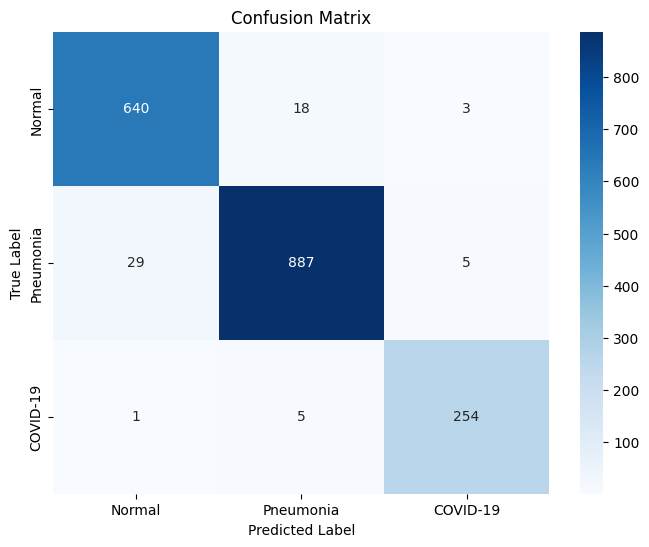

Classification Report:

              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96       661
   Pneumonia       0.97      0.96      0.97       921
    COVID-19       0.97      0.98      0.97       260

    accuracy                           0.97      1842
   macro avg       0.97      0.97      0.97      1842
weighted avg       0.97      0.97      0.97      1842



In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Gather true labels and top-1 predictions
true_labels = []  # True labels for each query
top1_predictions = []  # Top-1 predicted labels for each query

for i in range(len(test_embeddings)):
    query_embedding = test_embeddings[i].unsqueeze(0)
    query_label = test_labels[i].item()  # Convert to scalar if tensor

    # Retrieve top-1 result
    top_indices = retrieve_images(query_embedding, train_embeddings, top_k=1)
    top_label = train_labels[top_indices[0][0]].item()  # Get the top-1 label

    true_labels.append(query_label)
    top1_predictions.append(top_label)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, top1_predictions)
class_names = ["Normal", "Pneumonia", "COVID-19"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate Classification Report
report = classification_report(true_labels, top1_predictions, target_names=class_names)
print("Classification Report:\n")
print(report)

In [35]:
def display_retrieved_images(query_images, retrieved_images, query_labels, retrieved_labels, max_retrieved=10):
    # Label mapping dictionary
    label_mapping = {0: "Normal", 1: "Pneumonia", 2: "COVID-19"}
    
    # Number of queries to process
    num_queries = len(query_images)
    
    # Set up the plot with 1 row and (num_retrieved + 1) columns for each query
    fig, axes = plt.subplots(num_queries, max_retrieved + 1, figsize=(15, 5 * num_queries))
    
    if num_queries == 1:  # when we only have 1 query
        axes = [axes]
    
    for query_idx in range(num_queries):
        # Ensure the number of retrieved images does not exceed max_retrieved
        num_retrieved = min(len(retrieved_images[query_idx]), max_retrieved)
        
        # Display the query image with its label
        axes[query_idx][0].imshow(query_images[query_idx])
        axes[query_idx][0].set_title(f"Query Label: {label_mapping.get(query_labels[query_idx], 'Unknown')}")
        axes[query_idx][0].axis('off')
        
        # Display the retrieved images with their labels
        for i, (img, label) in enumerate(zip(retrieved_images[query_idx][:num_retrieved], retrieved_labels[query_idx][:num_retrieved])):
            axes[query_idx][i + 1].imshow(img)
            axes[query_idx][i + 1].set_title(f"Label: {label_mapping.get(label, 'Unknown')}")
            axes[query_idx][i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [38]:
# Select query indices from (0 to 299)
query_indices = [398, 85, 690, 50, 1299, 1740] 

query_images = [test_dataset[idx][0] for idx in query_indices] 
query_labels = [test_labels[idx].item() for idx in query_indices]  

# Retrieve most similar images 
top_k = 10
retrieved_images = []
retrieved_labels = []
for query_index in query_indices:
    query_embedding = test_embeddings[query_index].unsqueeze(0)
    top_indices = retrieve_images(query_embedding, train_embeddings, top_k=top_k)
    
    # Collect retrieved images and labels for the current query
    retrieved_images.append([train_dataset[idx][0] for idx in top_indices[0]])
    retrieved_labels.append([train_labels[idx] for idx in top_indices[0]])

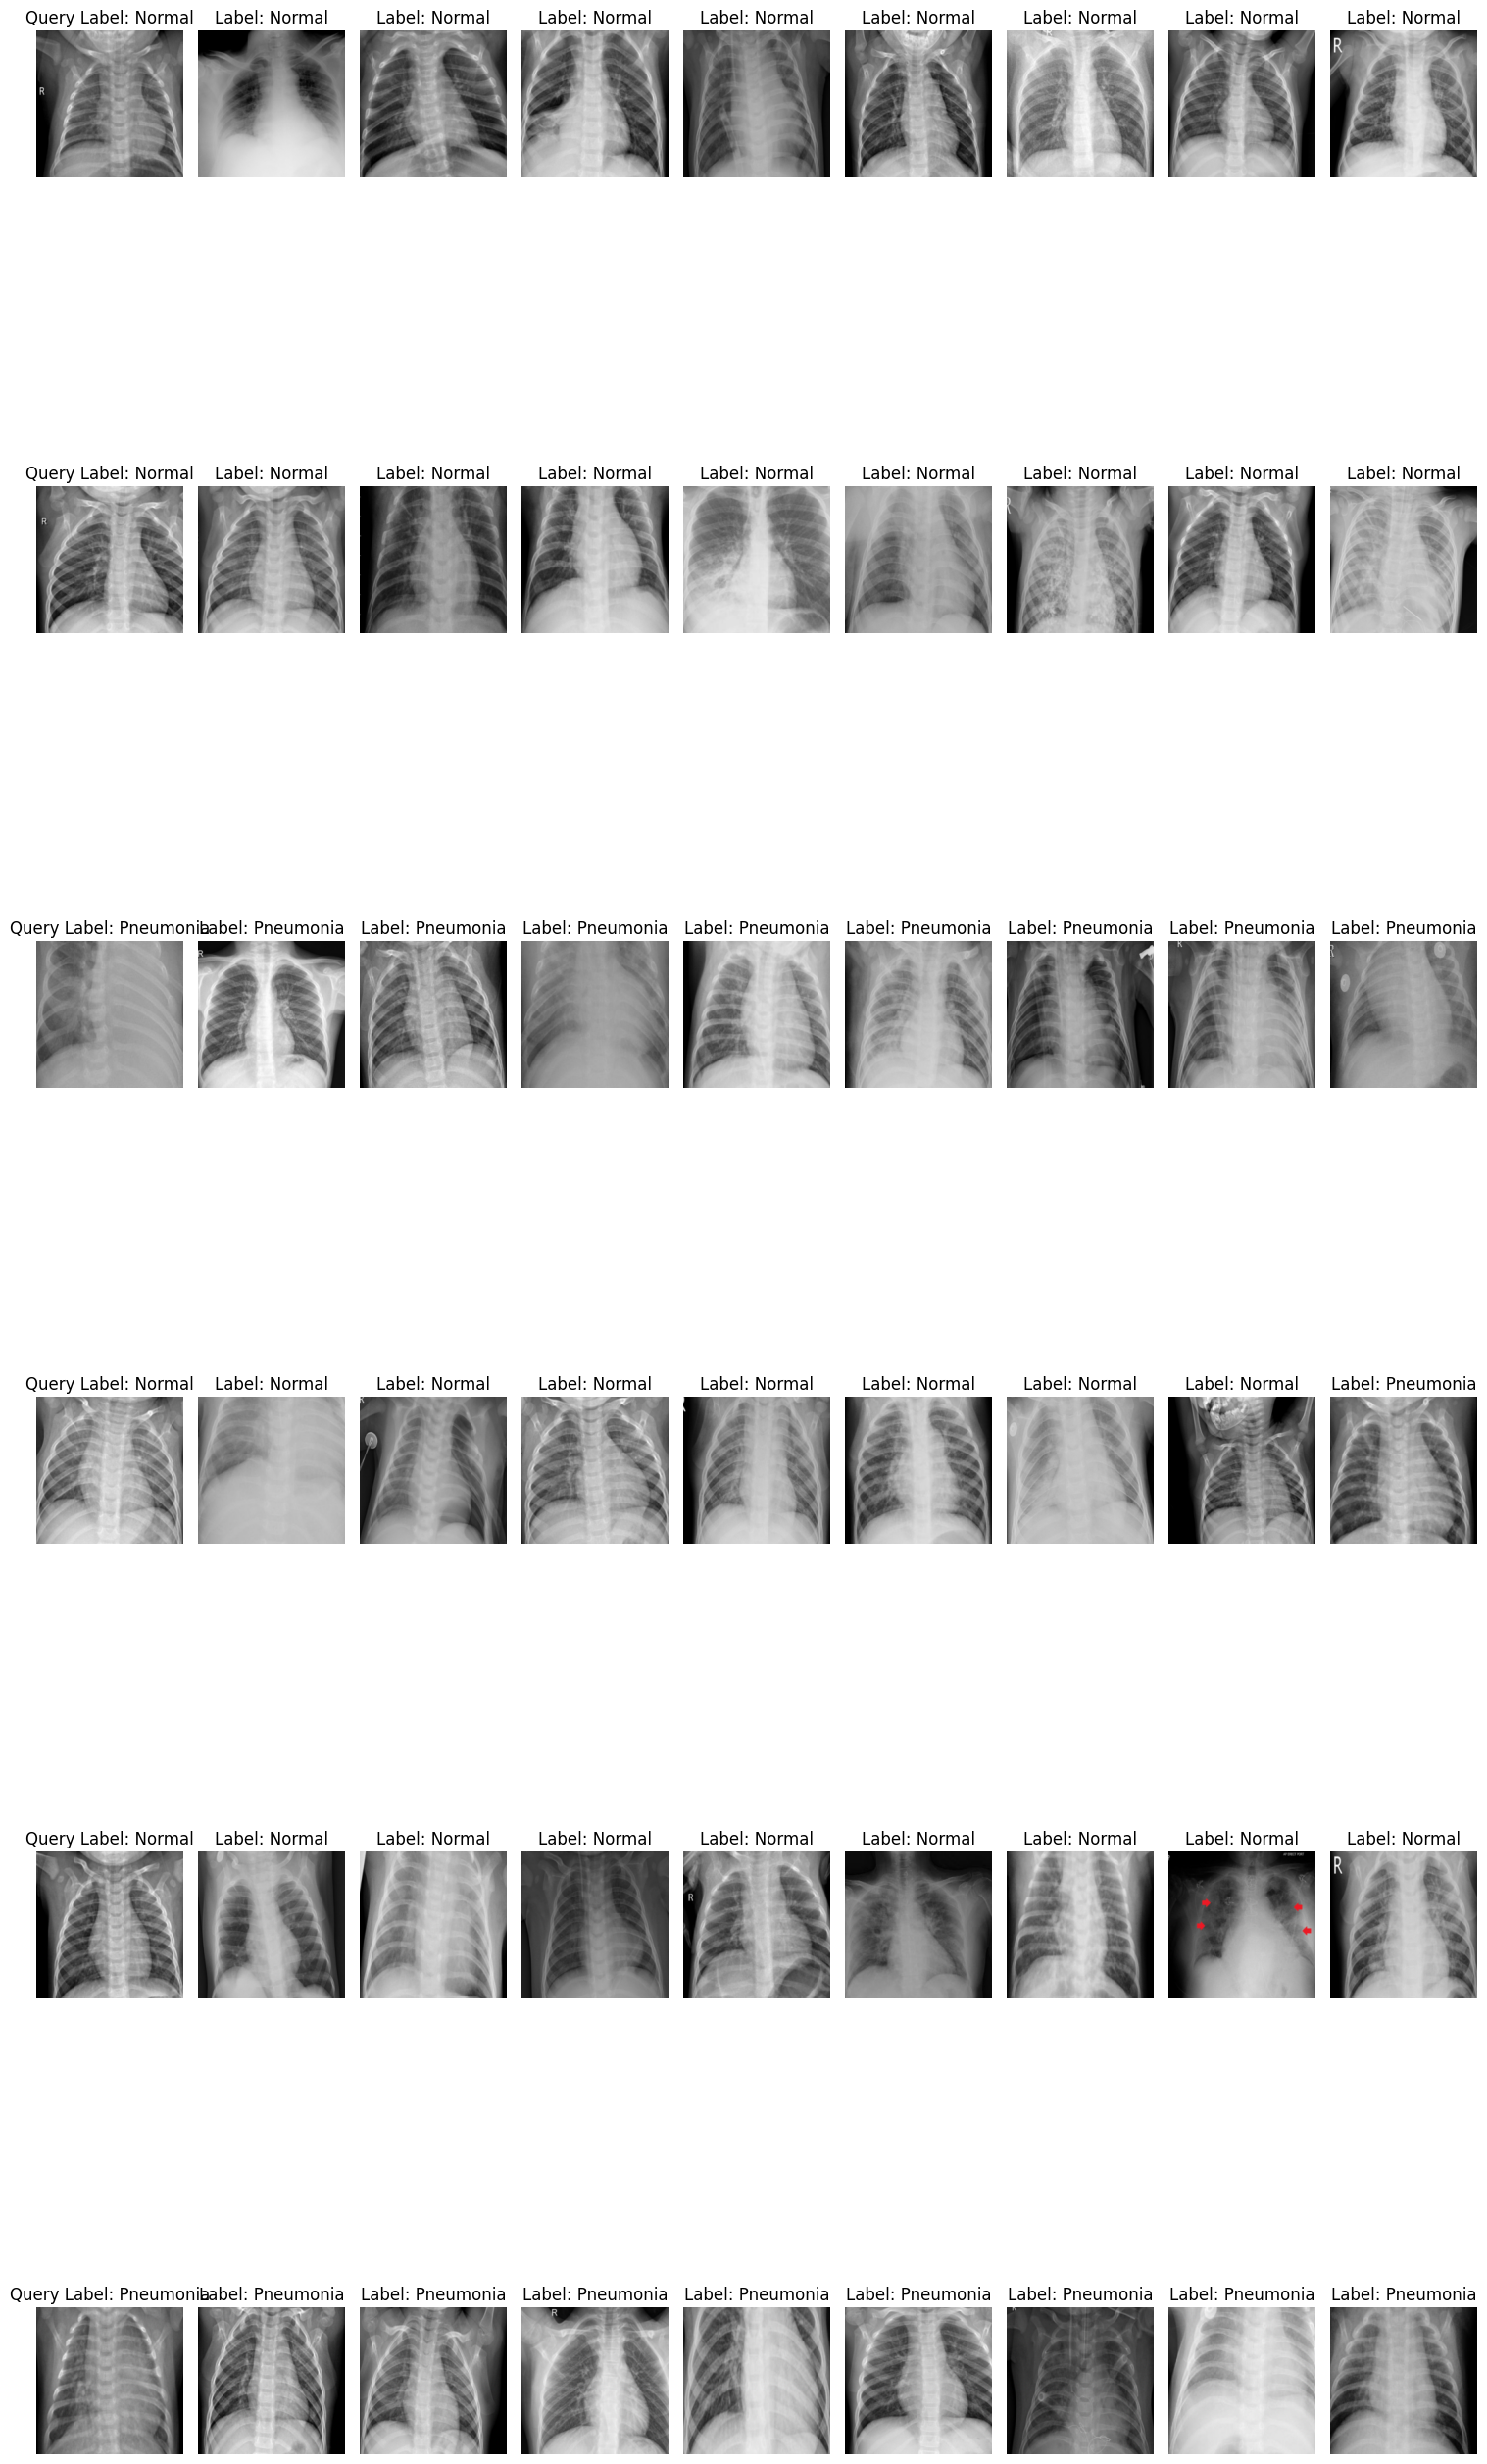

In [39]:
# Display the query images and retrieved images
display_retrieved_images(
    [img.permute(1, 2, 0).cpu().numpy() for img in query_images],  # Convert query images to HWC format
    [[img.permute(1, 2, 0).cpu().numpy() for img in imgs] for imgs in retrieved_images],
    query_labels,
    [[label.item() for label in labels] for labels in retrieved_labels],
    max_retrieved=8
)